In [ ]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 35.9MB/s]


In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (4200/4200), done.


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet/keras-retinanet
Processing /content/keras-retinanet/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168021 sha256=f3b56f5805dee6639ef5deeeff14dd19be736ab6fe9d9b8520af08a63e6f5740
  Stored in directory: /root/.cache/pip/wheels/cd/57/f4/f71ed948102bf00ffcf4eed03f64026c8935c9e71edfb34035
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-securi

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!ls

build		 images		  README.md	    setup.py
CONTRIBUTORS.md  keras_retinanet  requirements.txt  snapshots
examples	 LICENSE	  setup.cfg	    tests


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
import urllib
import os
import csv
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box,draw_caption
from keras_retinanet.utils.colors import label_color

In [ ]:
plates_df = pd.read_json('../indian_number_plates.json', lines=True)

In [ ]:
plates_df

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
...,...,...,...
232,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
233,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
234,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
235,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [ ]:
plates_df.annotation[236]

[{'imageHeight': 147,
  'imageWidth': 395,
  'label': ['number_plate'],
  'notes': '',
  'points': [{'x': 0.040506329113924, 'y': 0.129251700680272},
   {'x': 0.9291139240506321, 'y': 0.8571428571428571}]}]

In [ ]:
plates_df.content[5]

'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/18d2b870-7817-46da-a59a-6406c1b472c9___1033.png'

In [ ]:
os.makedirs("number_plates", exist_ok=True)

In [ ]:
dataset= dict()
dataset["image_name"]=list()
dataset["top_x"]= list()
dataset["top_y"]= list()
dataset["bottom_x"]= list()
dataset["bottom_y"]= list()
dataset["class_name"]= list()

counter=0
for index, row in plates_df.iterrows():
  img= urllib.request.urlopen(row["content"])
  img= Image.open(img)
  img= img.convert("RGB")
  img.save(f"number_plates/licenced_car_{counter}.jpeg","JPEG")

  dataset["image_name"].append(f"number_plates/licenced_car_{counter}.jpeg")
  data= row["annotation"]

  width= data[0]["imageWidth"]
  height= data[0]["imageHeight"]

  dataset["top_x"].append(int(round(data[0]["points"][0]["x"]*width)))
  dataset["top_y"].append(int(round(data[0]["points"][0]["y"]*height)))
  dataset["bottom_x"].append(int(round(data[0]["points"][1]["x"]*width)))
  dataset["bottom_y"].append(int(round(data[0]["points"][1]["y"]*height)))
  dataset["class_name"].append("license_plate")

  counter+=1
print("Downloaded {} car images".format(counter))

Downloaded 237 car images


In [ ]:
df= pd.DataFrame(dataset)

In [ ]:
df

,image_name,top_x,top_y,bottom_x,bottom_y,class_name
0,number_plates/licenced_car_0.jpeg,582,274,700,321,license_plate
1,number_plates/licenced_car_1.jpeg,80,382,288,449,license_plate
2,number_plates/licenced_car_2.jpeg,41,219,115,260,license_plate
3,number_plates/licenced_car_3.jpeg,217,313,359,359,license_plate
4,number_plates/licenced_car_4.jpeg,209,220,866,554,license_plate
...,...,...,...,...,...,...
232,number_plates/licenced_car_232.jpeg,172,223,353,285,license_plate
233,number_plates/licenced_car_233.jpeg,184,151,308,206,license_plate
234,number_plates/licenced_car_234.jpeg,167,202,314,255,license_plate
235,number_plates/licenced_car_235.jpeg,173,199,259,238,license_plate


In [ ]:
train_df, test_df= train_test_split(df,test_size=2, random_state=12)

In [ ]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [ ]:
train_df.to_csv(ANNOTATIONS_FILE,index=False,header= None)

In [ ]:
classes= set(["license_plate"])

with open (CLASSES_FILE,"w") as f:
  for i,line in enumerate(sorted(classes)):
    f.write("{},{}\n".format(line,i))

In [ ]:
os.makedirs("snapshots", exist_ok=True)

In [ ]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 157MB/s]


In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
!keras_retinanet/bin/train.py \
 --freeze-backbone \
 --random-transform \
 --weights {PRETRAINED_MODEL} \
 --batch-size 8 \
 --steps 500 \
 --epochs 10 \
 csv annotations.csv classes.csv

In [ ]:
model_path = os.path.join(
  'snapshots',
  sorted(os.listdir('snapshots'), reverse=True)[0]
)
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

In [ ]:
def show_image_objects(image_row):
  img_path= image_row.image_name
  box=[image_row.top_x, image_row.top_y,image_row.bottom_x,image_row.bottom_y]
  image= read_image_bgr(img_path)
  draw= image.copy()
  draw= cv2.cvtColor(draw,cv2.COLOR_BGR2RGB)
  draw_box(draw,box,color=(0,0,255))
  plt.axis("off")
  plt.imshow(draw)
  plt.show()


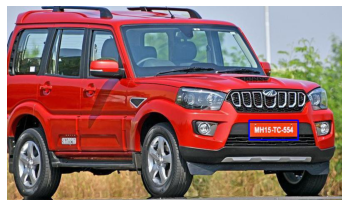

In [ ]:
show_image_objects(df.iloc[0])

In [ ]:
labels_to_names = pd.read_csv(
  CLASSES_FILE,
  header=None
).T.loc[0].to_dict()

In [ ]:
labels_to_names

{0: 'license_plate'}

In [ ]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)
  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )
  boxes /= scale
  return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.6
def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  image = read_image_bgr(img_path)
  boxes, scores, labels = predict(image)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  true_box = [
    image_row.top_x, image_row.top_y, image_row.bottom_x, image_row.bottom_y
  ]
  draw_box(draw, true_box, color=(255, 255, 0))
  draw_detections(draw, boxes, scores, labels)
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

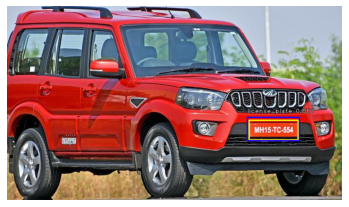

In [ ]:
show_detected_objects(df.iloc[0])